In [1]:
import os, sys
%pylab inline
from importlib import reload
from matplotlib import cycler
from matplotlib.gridspec import GridSpec
plt.style.use("default")

Populating the interactive namespace from numpy and matplotlib


In [2]:
base_dir = os.path.split(os.getcwd())[0]
print(f"{base_dir=}")
if base_dir not in sys.path:
    sys.path.append(base_dir)

base_dir='/camp/lab/schaefera/working/tootoos/git/crick-osn-tracking-release'


In [3]:
import osn

In [4]:
dt       = 1e-3   # Integration time constant
t_on     = 0.01   # Length of each pulse in seconds.
t_pre    = 0.1    # Time before first pulse in each trial.
t_trial  = 2      # Length of each trial in seconds.
tau_chem = 0.075  # Chemical transmission time constant
tau_osn  = 0.075  # OSN membrane time constant
sd       = 0.25   # Noise sd
seed     = 0      # Random seed

# Single OSN stimulation

In [5]:
n_trials1 = 500
pat    = "pS!" # Stimulation pattern
widths = {"p":t_pre, "S":t_on}
stim1  = osn.str2stim(pat, widths = widths, dt = dt, t_trial = t_trial, n_trials=n_trials1)[0]
th     = np.inf # No spikes
V1     = {amp:osn.run(stim1, amp, dt = dt, n_osn = 1, th = th, sd = sd, tau_osn = tau_osn, tau_chem = tau_chem, seed = seed)[0] for amp in [15, 150]}

# Full population stimulation

In [6]:
gaps = [0.025, 0.01]
stim3 = {}
V3, S3, t3 = {}, {}, {}
th  = 2   # Spikes allowed
amp = 15
n_trials = 20
for g in gaps:
    widths = {"p":t_pre, "S":t_on, "g":g}
    stim3[g], t3[g]  = osn.str2stim("pSgS!", widths=widths, t_trial=t_trial, n_trials=n_trials, dt=dt)
    V3[g], S3[g], *_ = osn.run(stim3[g], amp, dt = dt, n_osn = 5000, th = th, sd = sd, tau_osn = tau_osn, tau_chem = tau_chem, seed = seed)

In [7]:
# Mean spike rates
ss = {g: mean(S3[g],axis=1) for g in S3}    

In [8]:
# Ca2+ filter
tau_h = 0.15
t_h   = arange(0,t_trial,dt)
h     = t_h*exp(-t_h/tau_h)
sh    = {g:np.convolve(sg**2, h, 'valid') for g,sg in ss.items()}

In [9]:
n_av   = 15 # How many of the trials ot average over
offset = len(t_h)*3 # Where to start averaging from
nt     = int(t_trial/dt) # The length of a trial
sha = {g:sh1[offset:offset+nt*n_av].reshape(n_av, -1) for g, sh1 in sh.items()}

# Plot panels

(-2.2336074746828274, 3.773028927365849)


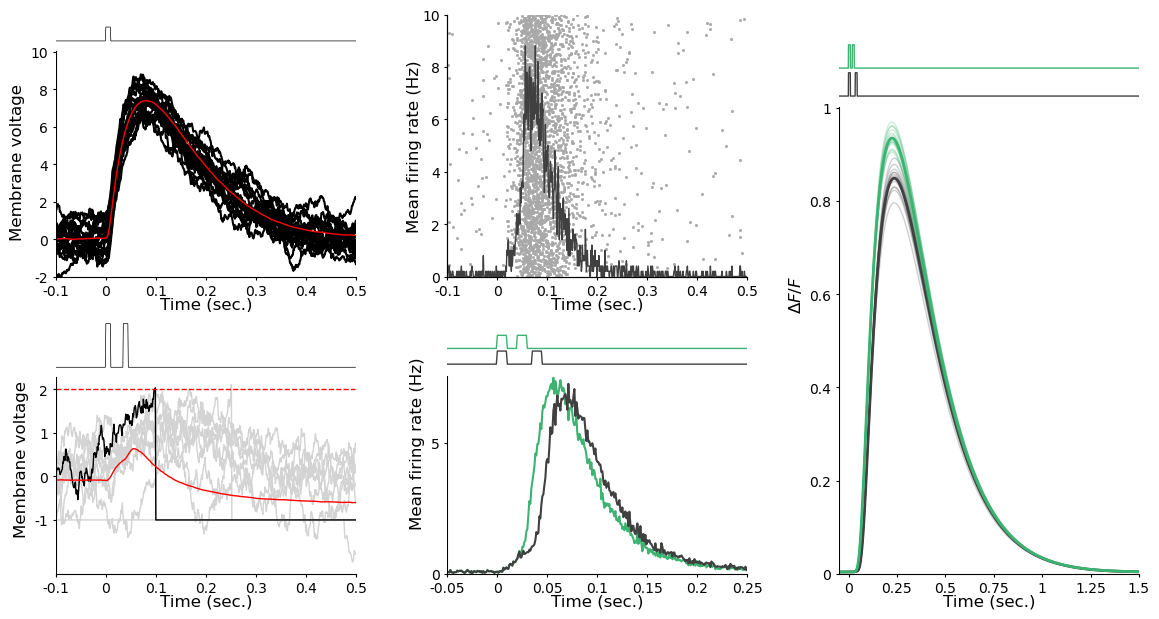

In [10]:
lab_sz = 12
ttl_sz = 14

xl = [-0.1,0.5]
xl_zoom = [-.05, 0.25]

mode = "zoom"

make_titles = False

figure(figsize=(11.4,6))
gs = GridSpec(2,3)

ax = subplot(gs[0,0])
amp = 150
if amp == 150:
    osn.plot_single_osn_response(ax, V1[amp], stim1/10, n_trials1, t_pre, dt, trace_col = "black")
    ax.spines["left"].set_visible(False)
    ax.set_yticks(range(-2,12,2))
    y0 = -2
    ax.plot([-t_pre, -t_pre],[y0, 10], "k") #[y0, np.max(V1[istim]/10)], "k")
elif amp == 15:
    osn.plot_single_osn_response(ax, V1[amp], stim1, n_trials1, t_pre, dt, trace_col = "lightgray", stim_scale = 1, stim_offset = 2.5)
    ax.spines["left"].set_visible(False)
    ylim(-1.65,3.75)
    y0 = ylim()[0]
    y1 = 2.25    
    ax.set_yticks(arange(-1,y1,1))
    ax.plot([-t_pre, -t_pre],[y0, y1], "k") #[y0, np.max(V1[istim]/10)], "k")
    
ax.set_yticklabels([f"{yt:g}".format(yt) for yt in ax.get_yticks()], fontsize=8)
ylim(y0, ylim()[1])
xlim(xl)
xt = arange(xl[0],xl[1]+1e-6,0.1)
ax.set_xticks(xt)
xlabel( "Time (sec.)", fontsize=lab_sz, labelpad=-1)
make_titles and title("Single OSN Odour Response", fontsize=ttl_sz)
ax.set_xticklabels([f"{xt:g}".format(xt) for xt in ax.get_xticks()], fontsize=8)
ax.set_ylabel("Membrane voltage      ", fontsize=lab_sz)
osn.setup_axes_for_poster(ax)

ax = subplot(gs[1,0])
g = 0.025
tplot = array([2, 2.6]) # Plot the second trial, so start at t = 2
iplot = arange(len(t3[g]))[(t3[g]>=tplot[0]) & (t3[g]<tplot[1])]
ax.set_prop_cycle(cycler('color', [osn.set_alpha(cm.gray(rand()*0.5 + 0.25),0.5) for i in range(10)]))
ax.plot(t3[g][iplot] - tplot[0] - t_pre, V3[g][iplot, :10],color="lightgray",linewidth=1)
ax.plot(t3[g][iplot] - tplot[0] - t_pre, V3[g][iplot, 6],"k",linewidth=1)
ax.plot(t3[g][iplot] - tplot[0] - t_pre, mean(V3[g][iplot,:], axis=1), "r", linewidth=1)
ax.plot(t3[g][iplot] - tplot[0] - t_pre, stim3[g][iplot]+2.5, "k", linewidth=0.5)
ax.plot(t3[g][iplot] - tplot[0] - t_pre, 2 + 0*t3[g][iplot], "r--", linewidth=1)
ax.spines["left"].set_visible(False)
yl = ylim()
y1 = 2.25
ax.set_yticks(arange(-1,y1,1))
ax.plot([-t_pre, -t_pre],[ylim()[0], y1], "k") #[y0, np.max(V1[istim]/10)], "k")
ax.set_ylim(yl)
ax.set_xlim(xl)
ax.set_xlabel( "Time (sec.)", labelpad=-1, fontsize=lab_sz)
ax.set_ylabel("Membrane voltage      ", fontsize=lab_sz)
make_titles and ax.set_title("Paired Pulse Response", fontsize=ttl_sz)
print(ylim())
osn.setup_axes_for_poster(ax)

# THE RASTER PLOT
ax = subplot(gs[0,1])
ax.spy(S3[g].T[:,iplot],markersize=1,color=[0.66, 0.66, 0.66]);
axis("auto")
xlim(0,len(iplot))
ylim(0, S3[g].shape[1])
ax.set_yticks([])
ax.spines["left"].set_visible(True)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel( "Time (sec.)", labelpad=-1, fontsize=lab_sz)
ax1 = ax.twinx()
ax1.plot(mean(S3[g][iplot,:],axis=1)/dt, color=osn.cols[0.025], linewidth=1)
ax1.set_ylim(0,10)
ax1.yaxis.set_ticks_position('left')
ylabel("Mean firing rate (Hz)", labelpad=-245, fontsize=lab_sz)
osn.setup_axes_for_poster(ax)
osn.setup_axes_for_poster(ax1)
ax.set_xticks(arange(0,601,100))
ax.set_xticklabels([f"{(s-100)/1000:g}" for s in ax.get_xticks()])
make_titles and title("Population Response", fontsize=ttl_sz)

ax = subplot(gs[1,1])
t_plotm = array([0, 0.5])
for g in osn.cols:
    S3m = mean(mean(S3[g],axis=1).reshape(n_trials,-1),axis=0)
    tm = arange(len(S3m))*dt - t_pre
    ax.plot(tm, S3m/dt, color=osn.cols[g])
xlim(xl if mode == "normal" else xl_zoom)
ax.set_yticks([0,5])
ax.spines['left'].set_visible(False)
plot(array([0,0])+xlim()[0],[0,7.5], "k")
ax.plot(tm, stim3[0.01][:len(tm)]*0.5+8.6, linewidth=1, color=osn.cols[0.01])
ax.plot(tm, stim3[0.025][:len(tm)]*0.5+8, linewidth=1, color=osn.cols[0.025])
osn.setup_axes(ax)
ylim(0,10)
ylabel("Mean firing rate (Hz)", fontsize=lab_sz)
xlabel( "Time (sec.)", labelpad=-1, fontsize=lab_sz)
make_titles and title("Population Responses\nDistinguish Stimuli", fontsize=ttl_sz)
osn.setup_axes_for_poster(ax)

ax = subplot(gs[:,2])
for g in sha:
    a = sha[g]*10**4/1.5
    ta = arange(a.shape[1])*dt - t_pre
    plot(ta,a.T, color=osn.set_alpha(osn.cols[g],0.25), linewidth=1)
    plot(ta,mean(a,axis=0), color=osn.cols[g], linewidth=2)
xlim(-0.05,1.5)
ylim(0,1.2)    
osn.setup_axes(ax)
ax.spines["left"].set_visible(False)
ax.set_yticks(arange(0,1.1,0.2))
ax.plot(array([0,0])+xlim()[0],[0,1],"k")
ax.plot(tm, stim3[0.01][:len(tm)]*0.05 + 1.085, linewidth=1, color=osn.cols[0.01])
ax.plot(tm, stim3[0.025][:len(tm)]*0.05 + 1.025, linewidth=1, color=osn.cols[0.025])
xlabel( "Time (sec.)", labelpad=-1, fontsize=lab_sz)
ylabel("$\Delta F / F$", fontsize=lab_sz)
make_titles and title("Calcium Responses\nDistinguish Stimuli", fontsize=ttl_sz)
osn.setup_axes_for_poster(ax)

tight_layout(pad = 0, h_pad = 0)
savefig(f"osn_poster_{mode}.pdf", bbox_inches="tight")
